# Predicting NYC taxi trip duration

In [269]:
%matplotlib inline
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns',100)
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [270]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [271]:
df.shape

(729322, 11)

In [272]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [146]:
route1 = pd.read_csv('osrm/fastest_routes_train_part_1.csv',usecols=['id','total_distance','total_travel_time'])
route1.shape

(700000, 3)

In [147]:
route2 = pd.read_csv('osrm/fastest_routes_train_part_2.csv',usecols=['id','total_distance','total_travel_time'])
route2.shape

(758643, 3)

In [148]:
df_street_info = pd.concat((route1, route2))
data = pd.merge(df_street_info,data,on='id',how='inner')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


In [273]:
# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

In [274]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration'])

# Add some datetime features
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.isocalendar()['week']
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
df.loc[:, 'pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

### Eucledian Distance

In [275]:

#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5



### Haversine Distance

In [276]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)


In [277]:
### Binned Coordinates ###
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

In [278]:
df.vendor_id.value_counts()

vendor_id
2    390481
1    338841
Name: count, dtype: int64

In [279]:
df['vendor_id'] = df['vendor_id'] - 1

In [280]:
# For a route, the total distance and travel time are not available. Let's impute that with 0
df.fillna(0, inplace = True)

In [281]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration','store_and_fwd_flag'], axis=1)

## Model Building

In [283]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,dist_sq,dist_sqrt,haversine_distance,direction,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,1,1,-73.953918,40.778873,-73.963875,40.771164,0,9,16,40,5157547.0,16,0.000159,0.012592,1.199073,-135.634530,40.779,-73.954,40.771,-73.964
1,0,2,-73.988312,40.731743,-73.994751,40.694931,4,10,23,35,6132863.0,119,0.001397,0.037371,4.129111,-172.445217,40.732,-73.988,40.695,-73.995
2,1,2,-73.997314,40.721458,-73.948029,40.774918,6,7,17,59,4471099.0,161,0.005287,0.072712,7.250753,34.916093,40.721,-73.997,40.775,-73.948
3,1,6,-73.961670,40.759720,-73.956779,40.780628,1,1,9,44,380597.0,33,0.000461,0.021473,2.361097,10.043567,40.760,-73.962,40.781,-73.957
4,0,1,-74.017120,40.708469,-73.988182,40.740631,2,7,6,42,4084869.0,54,0.001872,0.043264,4.328534,34.280582,40.708,-74.017,40.741,-73.988


### Cross Validation

In [284]:
from math import sqrt
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index].values,df1.loc[test_index].values
        ytr,yvl = df_y[train_index].values,df_y[test_index].values

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

### Ensemble models

In [285]:
rf_params = {'random_state': 0, 'n_estimators': 19, 'max_depth': 11, 'n_jobs': -1, "min_samples_split": 43}
rf_scores = cv_score(RandomForestRegressor(**rf_params))


1 of kfold 5
Valid RMSE: 0.43130

2 of kfold 5
Valid RMSE: 0.43196

3 of kfold 5
Valid RMSE: 0.42200

4 of kfold 5
Valid RMSE: 0.42666

5 of kfold 5
Valid RMSE: 0.42483


### XGboost

In [287]:
#Splitting the data into df and Validation set
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

In [288]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dvalid = xgb.DMatrix(xtest, label=ytest)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [289]:
xgb_params = {}
xgb_params["objective"] = "reg:linear"
xgb_params['eval_metric'] = "rmse"
xgb_params["eta"] = 0.05
xgb_params["min_child_weight"] = 10
xgb_params["subsample"] = 0.9
xgb_params["colsample_bytree"] = 0.7
xgb_params["max_depth"] = 5
xgb_params['silent'] = 1
xgb_params["seed"] = 2019
xgb_params["nthread"] = -1
xgb_params["lambda"] = 2

xgb_model = xgb.train(xgb_params, dtrain, 10000, watchlist, early_stopping_rounds=50,
      maximize=False, verbose_eval=20)
print('Modeling RMSE %.5f' % xgb_model.best_score)

[0]	train-rmse:0.76801	valid-rmse:0.77385
[20]	train-rmse:0.51954	valid-rmse:0.52491
[40]	train-rmse:0.46445	valid-rmse:0.46997
[60]	train-rmse:0.44468	valid-rmse:0.45024
[80]	train-rmse:0.43352	valid-rmse:0.43927
[100]	train-rmse:0.42513	valid-rmse:0.43118
[120]	train-rmse:0.41971	valid-rmse:0.42605
[140]	train-rmse:0.41554	valid-rmse:0.42216
[160]	train-rmse:0.41228	valid-rmse:0.41914
[180]	train-rmse:0.40957	valid-rmse:0.41671
[200]	train-rmse:0.40745	valid-rmse:0.41488
[220]	train-rmse:0.40545	valid-rmse:0.41319
[240]	train-rmse:0.40352	valid-rmse:0.41160
[260]	train-rmse:0.40203	valid-rmse:0.41039
[280]	train-rmse:0.40063	valid-rmse:0.40935
[300]	train-rmse:0.39940	valid-rmse:0.40842
[320]	train-rmse:0.39823	valid-rmse:0.40749
[340]	train-rmse:0.39706	valid-rmse:0.40674
[360]	train-rmse:0.39619	valid-rmse:0.40614
[380]	train-rmse:0.39518	valid-rmse:0.40539
[400]	train-rmse:0.39429	valid-rmse:0.40485
[420]	train-rmse:0.39333	valid-rmse:0.40422
[440]	train-rmse:0.39259	valid-rmse:0.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

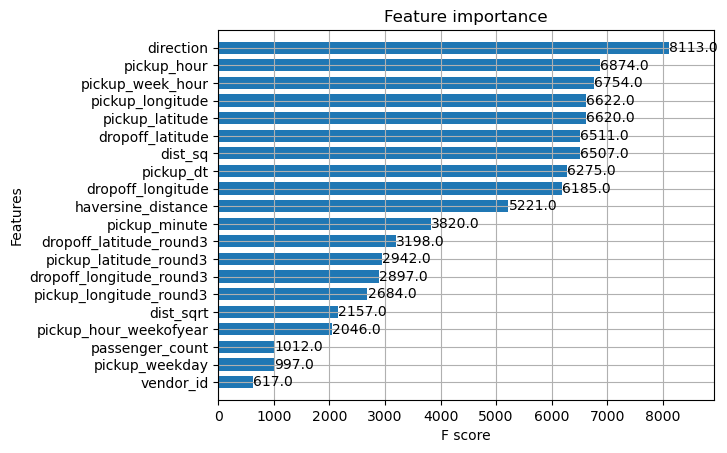

In [290]:
xgb.plot_importance(xgb_model, max_num_features=28, height=0.7)

In [291]:
xgb_params['num_round'] = xgb_model.best_iteration
xgb_model_final = xgb.XGBRegressor()
xgb_scores = cv_score(xgb_model_final)


1 of kfold 5
Valid RMSE: 0.40064

2 of kfold 5
Valid RMSE: 0.40189

3 of kfold 5
Valid RMSE: 0.39241

4 of kfold 5
Valid RMSE: 0.39583

5 of kfold 5
Valid RMSE: 0.39271


### Averaging

In [292]:
def cv_score_avg(ml_model_1, ml_model_2,w1 = 0.5, w2 = 0.5, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model_1
        ml_model_1.fit(xtr, ytr)
        pred_val_1 = ml_model_1.predict(xvl)
        
        model = ml_model_2
        ml_model_2.fit(xtr, ytr)
        pred_val_2 = ml_model_2.predict(xvl)
        
        final_pred=(pred_val_1*w1 + pred_val_2*w2)

        rmse_score = sqrt(mean_squared_error(yvl, final_pred))
        
        sufix = ""
        msg = ""
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

In [293]:
avg_scores = cv_score_avg(xgb_model_final, RandomForestRegressor(**rf_params), w1 = 0.4, w2 = 0.6)


1 of kfold 5
Valid RMSE: 0.40975

2 of kfold 5
Valid RMSE: 0.41075

3 of kfold 5
Valid RMSE: 0.40083

4 of kfold 5
Valid RMSE: 0.40491

5 of kfold 5
Valid RMSE: 0.40257


### Stacking

In [294]:
# Model Definitions for feeding into Stacking
xgb_model = xgb.XGBRegressor(**xgb_params)
rf_model = RandomForestRegressor(**rf_params)
tree_model = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)

In [296]:
# Importing Stacking regressor from mlxtend
from mlxtend.regressor import StackingCVRegressor

stacked_model = StackingCVRegressor(
    regressors=[xgb_model, rf_model],
    meta_regressor=Ridge()
)

In [297]:
stacking_scores = cv_score(stacked_model)


1 of kfold 5
Valid RMSE: 0.42614

2 of kfold 5
Valid RMSE: 0.42723

3 of kfold 5
Valid RMSE: 0.41715

4 of kfold 5
Valid RMSE: 0.42111

5 of kfold 5
Valid RMSE: 0.41924


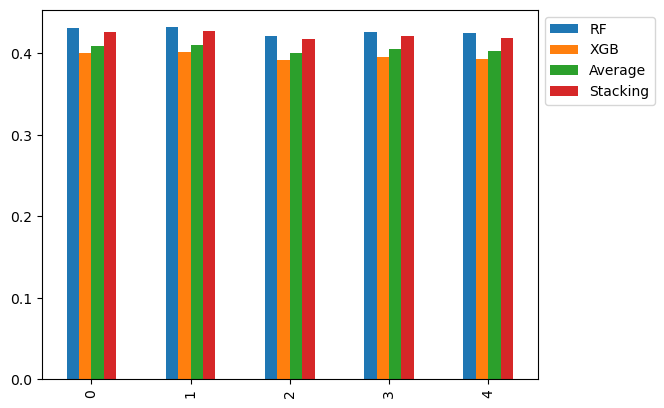

In [307]:
results_df = pd.DataFrame({'RF':rf_scores, 'XGB': xgb_scores, 'Average': avg_scores, 'Stacking':stacking_scores})
results_df.plot(y=["RF", "XGB","Average","Stacking"], kind="bar")
plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left')

* XGb gives the best prediction among the models and ensemble methods used here.